Import Data from Kaggle by API

In [1]:
from google.colab import files
files.upload()

In [2]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download catherinehorng/dogbreedidfromcomp

! unzip dogbreedidfromcomp.zip

Import Library

In [3]:
import pandas as pd
import numpy as np
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df = pd.read_csv('labels.csv')

df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
df.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [5]:
df.breed.nunique(), df.breed.unique()

(120,
 array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
        'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
        'shetland_sheepdog', 'walker_hound', 'maltese_dog',
        'norfolk_terrier', 'african_hunting_dog',
        'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
        'doberman', 'otterhound', 'standard_schnauzer',
        'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
        'affenpinscher', 'labrador_retriever', 'ibizan_hound',
        'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
        'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
        'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
        'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
        'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
        'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
        'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'pap

Select only 3 breeds due to performance of computation power

In [6]:
target_breed = ['chihuahua', 'pomeranian', 'maltese_dog']
df_target = df[df['breed'].isin(target_breed)].reset_index(drop = True)

In [7]:
df_target

,id,breed
0,00693b8bc2470375cc744a6391d397ec,maltese_dog
1,0206c12e8984e3c8a166cc272de25d6f,chihuahua
2,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
3,03dfefdb2939388f7ca9578cb7c4a2b9,maltese_dog
4,053106ed091eac5e129225315ef6cfcb,maltese_dog
...,...,...
294,f98392bfae7d0aa35ecc4993ee2afbaf,maltese_dog
295,fa5054c5187c7171c546bd6a46b8346f,maltese_dog
296,fdcbedc65f600f81df181e9a46858cbb,chihuahua
297,ff7d9c08091acc3b18b869951feeb013,maltese_dog


In [8]:
df_target['breed'].value_counts()

maltese_dog    117
pomeranian     111
chihuahua       71
Name: breed, dtype: int64

Join path and show instance picture

In [9]:
from google.colab.patches import cv2_imshow

In [10]:
img_dir = '/content/train/'
df_target['path_id'] = df_target['id'].apply(lambda x : img_dir + x + '.jpg')
df_target = df_target.drop('id', axis = 1)


In [11]:
df_target['path_id'][0]

'/content/train/00693b8bc2470375cc744a6391d397ec.jpg'

maltese_dog


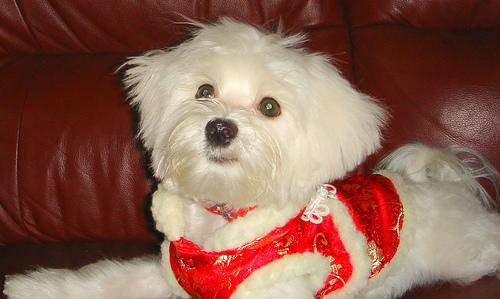

In [12]:
image = cv.imread(df_target['path_id'][0])
print(df_target['breed'][0])
cv2_imshow(image)

Import split model

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_target, test_size = 0.3, shuffle = True, random_state = 42)

In [14]:
train['breed'].value_counts()

pomeranian     79
maltese_dog    77
chihuahua      53
Name: breed, dtype: int64

In [15]:
test['breed'].value_counts()

maltese_dog    40
pomeranian     32
chihuahua      18
Name: breed, dtype: int64

Generate dataset to perform CNN by ImageDataGenerator



In [16]:
train_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    validation_split = 0.2
)


test_generator = ImageDataGenerator(
    rescale = 1./255
    )

train_image = train_generator.flow_from_dataframe(
    dataframe = train,
    x_col = 'path_id',
    y_col = 'breed',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    subset = 'training',
    seed = 42
)

validation_images = train_generator.flow_from_dataframe(
    dataframe = train,
    x_col = 'path_id',
    y_col = 'breed',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    subset = 'validation',
    seed = 42
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test,
    x_col = 'path_id',
    y_col = 'breed',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)


Found 168 validated image filenames belonging to 3 classes.
Found 41 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.


Perform modeling

- model below is baseline model

In [17]:
# input = tf.keras.Input(shape = (224,224,3))
# x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(input)
# x = tf.keras.layers.MaxPool2D()(x)
# x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)
# x = tf.keras.layers.MaxPool2D()(x)
# x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu')(x)
# x = tf.keras.layers.MaxPool2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.4)(x)
# x = tf.keras.layers.Dense(512, activation = 'relu')(x)
# outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

# model = tf.keras.Model(inputs = input, outputs=outputs)

# model.compile(
#     optimizer = 'adam',
#     loss = 'categorical_crossentropy',
#     metrics = ['accuracy']
# )

In [18]:
# print(model.summary())

In [19]:
# history = model.fit(
#     train_image,
#     validation_data = validation_images,
#     epochs = 100,
#     callbacks = [
#                  tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=6,
#     restore_best_weights = True)]
# )

In [20]:
# prediction = np.argmax(model.predict(test_images), axis = 1)
# true_labels = test_images.labels

Import metrics of evaluate model

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# accuracy_score(true_labels, prediction)

In [22]:
# confusion_matrix(true_labels, prediction)

- Improve model

In [23]:

input = tf.keras.Input(shape = (224,224,3))
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')(input)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu', kernel_regularizer = 'l2')(x)
outputs = tf.keras.layers.Dense(3, activation = 'sigmoid')(x)

model2 = tf.keras.Model(inputs = input, outputs=outputs)
model2.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [24]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464 

In [25]:
history = model2.fit(
    train_image,
    validation_data = validation_images,
    epochs = 100,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights = True)]
)

Epoch 1/100
6/6 [==============================] - 10s 1s/step - loss: 2.7691 - accuracy: 0.3571 - val_loss: 2.6007 - val_accuracy: 0.3902
Epoch 2/100
6/6 [==============================] - 3s 475ms/step - loss: 2.5421 - accuracy: 0.3810 - val_loss: 2.4212 - val_accuracy: 0.4634
Epoch 3/100
6/6 [==============================] - 2s 464ms/step - loss: 2.3573 - accuracy: 0.3810 - val_loss: 2.3933 - val_accuracy: 0.2927
Epoch 4/100
6/6 [==============================] - 3s 474ms/step - loss: 2.2229 - accuracy: 0.4286 - val_loss: 2.1234 - val_accuracy: 0.5122
Epoch 5/100
6/6 [==============================] - 2s 401ms/step - loss: 2.0299 - accuracy: 0.5655 - val_loss: 1.9698 - val_accuracy: 0.4878
Epoch 6/100
6/6 [==============================] - 2s 269ms/step - loss: 1.8511 - accuracy: 0.5357 - val_loss: 1.9583 - val_accuracy: 0.4634
Epoch 7/100
6/6 [==============================] - 2s 293ms/step - loss: 1.6896 - accuracy: 0.5893 - val_loss: 1.7756 - val_accuracy: 0.4634
Epoch 8/100
6/6

In [26]:
prediction2 = np.argmax(model2.predict(test_images), axis = 1)
true_labels = test_images.labels

log of model improving

Improving with R2 score

1. base line 
: 0.5111111111111111 
2. Increase filter (Double)
: 0.5777777777777777
3. Change output activation > sigmoid
: 0.5888888888888889
4. Derease filter Dense layer (/2)
: 0.6333333333333333
5. Add layer dense128 with kernel_regularizer
: 0.6444444444444445





Evaluate model

In [28]:
cm = confusion_matrix(true_labels, prediction2)

In [29]:
list(test_images.class_indices.keys())

['chihuahua', 'maltese_dog', 'pomeranian']

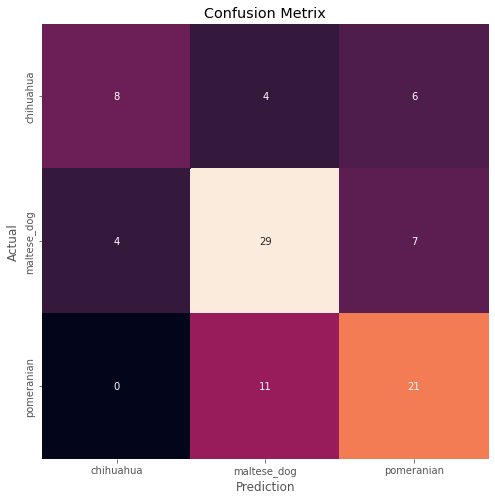


************************* Classification report
               precision    recall  f1-score   support

   chihuahua       0.67      0.44      0.53        18
 maltese_dog       0.66      0.72      0.69        40
  pomeranian       0.62      0.66      0.64        32

    accuracy                           0.64        90
   macro avg       0.65      0.61      0.62        90
weighted avg       0.65      0.64      0.64        90



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, cbar = False, vmin = 0)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.xticks(ticks = [0.5,1.5,2.5], labels = list(test_images.class_indices.keys()))
plt.yticks(ticks = [0.5,1.5,2.5], labels = list(test_images.class_indices.keys()))
plt.title('Confusion Metrix')
plt.show()

print('')
print('************************* Classification report\n' , classification_report(true_labels, prediction2, target_names = list(test_images.class_indices.keys())))

Testing model

In [31]:
import urllib.request

In [71]:
def predict_from_url(url):
  try:
    url = url
    url_response = urllib.request.urlopen(url)
    img = cv.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8), -1)
    opencv_image = cv.resize(img, (224,224))
    opencv_image.shape = (1,224,224,3)
    pred = model2.predict(opencv_image)
    result = np.argmax(pred ,axis = 1)
    print('Prediction : {}\n'.format(list(test_images.class_indices.keys())[result[0]]))
    cv2_imshow(img)
  except:
    print('Something wrong.. retry with new link')

Prediction : chihuahua



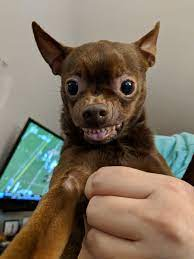

In [80]:
predict_from_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTXl8s5WBtSkcb6on90PaqIvn55_YeYIngP7WXlxyBuI-UyZF58rCnanCxOS061tY-XQSU&usqp=CAU')